# Experiment - KLD for Reward Regularization

## Prepare Notebook

In [1]:
if False:
    %pip install gym==0.23.0
    %pip install matplotlib==3.8.2
    %pip install numpy==2.2.1
    %pip install openai==1.59.8
    %pip install pandas==2.2.3
    %pip install polars==1.20.0
    %pip install protobuf==3.20.3
    %pip install pydantic==2.10.5
    %pip install python-dotenv==1.0.1
    %pip install PyYAML==6.0.2
    %pip install scikit_learn==1.4.0
    %pip install scipy==1.15.1
    %pip install statsmodels==0.14.1
    %pip install tabulate==0.9.0
    %pip install torch==2.4.1
    %pip install tqdm==4.66.5


In [2]:
import os
import sys
import logging
import warnings
warnings.filterwarnings("ignore")

%load_ext dotenv

MODELS_PATH = os.getenv("MODELS_PATH")
HISTORIC_PATH = os.getenv("HISTORIC_PATH")
LLM_OUTPUT_PATH = os.getenv("LLM_OUTPUT_PATH")
LLM_PROMPTS_PATH = os.getenv("LLM_PROMPTS_PATH")
LOGS_PATH = os.getenv("LOGS_PATH")
paths = [LLM_OUTPUT_PATH, LOGS_PATH, MODELS_PATH]
for path in paths:
    if path and not os.path.exists(path):
        os.makedirs(path)

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    logging.info("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/drl-dataset-quant"
    HISTORIC_PATH = DATA_PATH + HISTORIC_PATH
    LLM_PROMPTS_PATH = DATA_PATH + LLM_PROMPTS_PATH

    sys.path.insert(1, "/kaggle/usr/lib/drlutil")

In [3]:
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from openai import OpenAI

module_path = os.path.abspath(os.path.join(os.getcwd(), 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Initialize LLM

In [4]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")
OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)

# Run LLM+RL

In [5]:
from thesis_utils import TradingSimulator, PerformanceEstimator
from data_utils import generate_strategy_for_ticker, PERSONA, HIGH_OBJECTIVES, HIGH_RISK_PROFILE

2025-02-08 10:04:52.974274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 10:04:53.305823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 10:04:53.305878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 10:04:53.374777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 10:04:53.516365: I tensorflow/core/platform/cpu_feature_guar

In [6]:
strategy = "TDQN"
money=100000.
stateLength = 30
observationSpace =  (stateLength - 1) * 5
actionSpace = 2
bounds = [1, 30]
step = 1
numberOfEpisodes = 50
percentageCosts = [0, 0.1, 0.2]
transactionCosts = percentageCosts[1]/100
simulator = TradingSimulator()

TARGET = 'AAPL'
STARTDATE = '2012-01-01'
SPLITDATE = '2018-01-01'
ENDDATE = '2020-01-01'

In [7]:
train_file = f'./{TARGET}_train_results.pkl'
test_file = f'./{TARGET}_test_results.pkl'
train_env_file = f'./{TARGET}_train_env.pkl'
test_env_file = f'./{TARGET}_test_env.pkl'
input_file = f"{HISTORIC_PATH}/engineered_{TARGET}_data.parquet"

engineered_df = pd.read_parquet(input_file)
engineered_df.set_index('Date', inplace=True)

engineered_df.tail(1)

,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Volume_Weighted_Returns,BB_Upper,BB_Middle,BB_Lower,BB_Width,IV_Percentile,VIX_Impact,Momentum_Long,Momentum_Short,content
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30 00:00:00+00:00,134.05,134.73,131.73,132.69,11174161.0,0.384131,0.387116,0.376623,0.383544,1.0,...,38908.628047,137.323588,133.988,130.652412,0.050276,1.0,108.299927,True,False,"[<p>In the exchange traded funds industry, rec..."


Generating strategies for AAPL:   0%|          | 0/1997 [00:00<?, ?it/s]

Training progression (hardware selected => cuda:0):


Training TQDM..:   0%|          | 0/50 [00:00<?, ?it/s]

╒═══════════════════════════╤══════════════╕
│   Performance Indicator   │  TDQN Train  │
╞═══════════════════════════╪══════════════╡
│    Profit & Loss (P&L)    │    32375     │
├───────────────────────────┼──────────────┤
│     Cumulative Return     │    0.47%     │
├───────────────────────────┼──────────────┤
│     Annualized Return     │    6.61%     │
├───────────────────────────┼──────────────┤
│   Annualized Volatility   │    25.07%    │
├───────────────────────────┼──────────────┤
│       Sharpe Ratio        │    0.313     │
├───────────────────────────┼──────────────┤
│       Sortino Ratio       │    0.428     │
├───────────────────────────┼──────────────┤
│     Maximum Drawdown      │    48.62%    │
├───────────────────────────┼──────────────┤
│  Mean Drawdown Duration   │  61.87 days  │
├───────────────────────────┼──────────────┤
│       Profitability       │    52.43%    │
├───────────────────────────┼──────────────┤
│ Ratio Average Profit/Loss │    1.096     │
├─────────

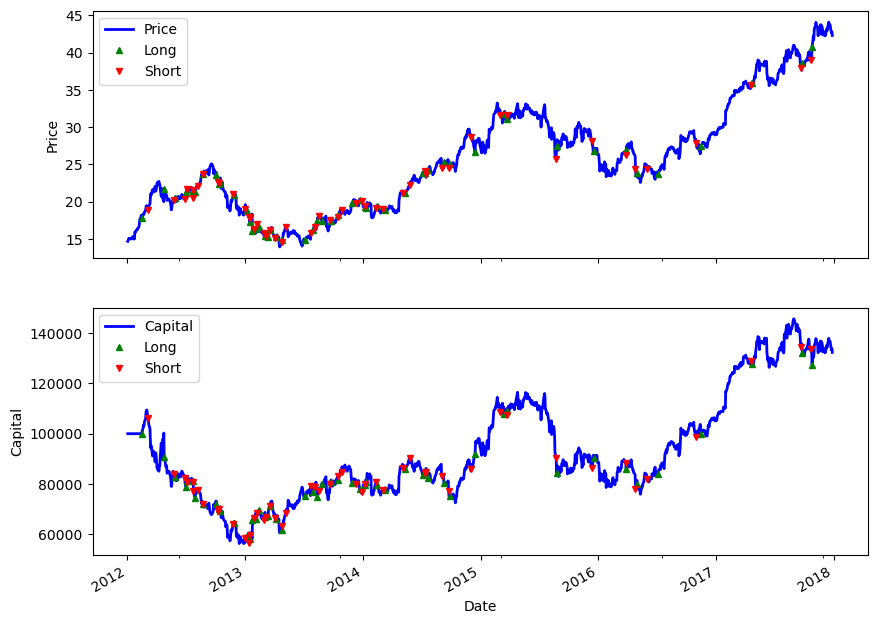

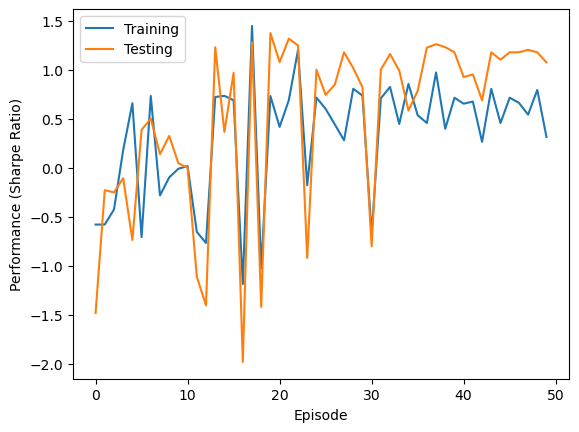

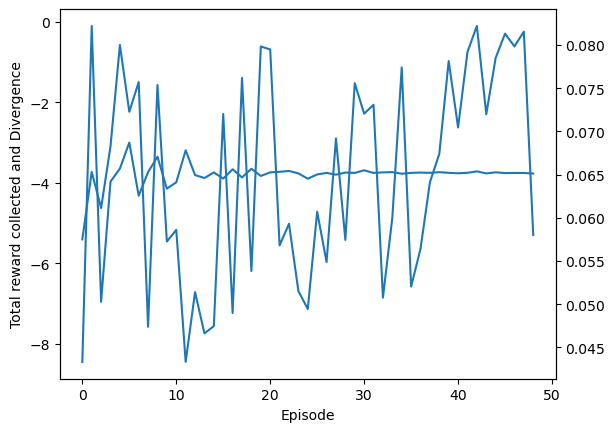

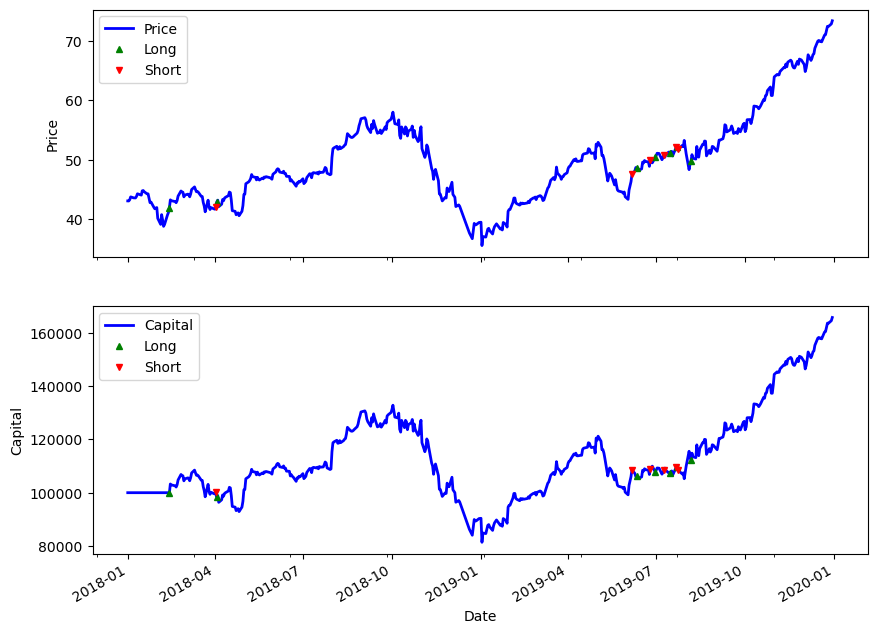

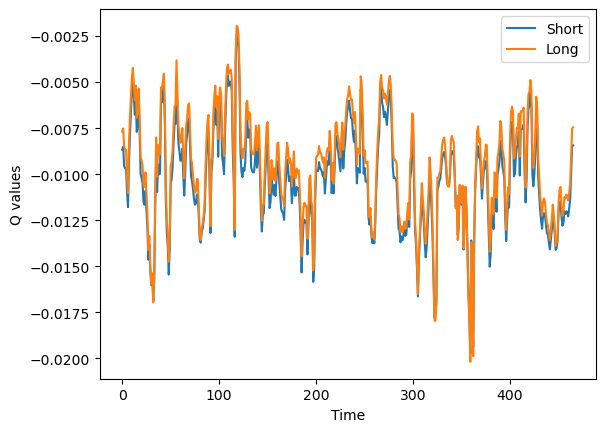

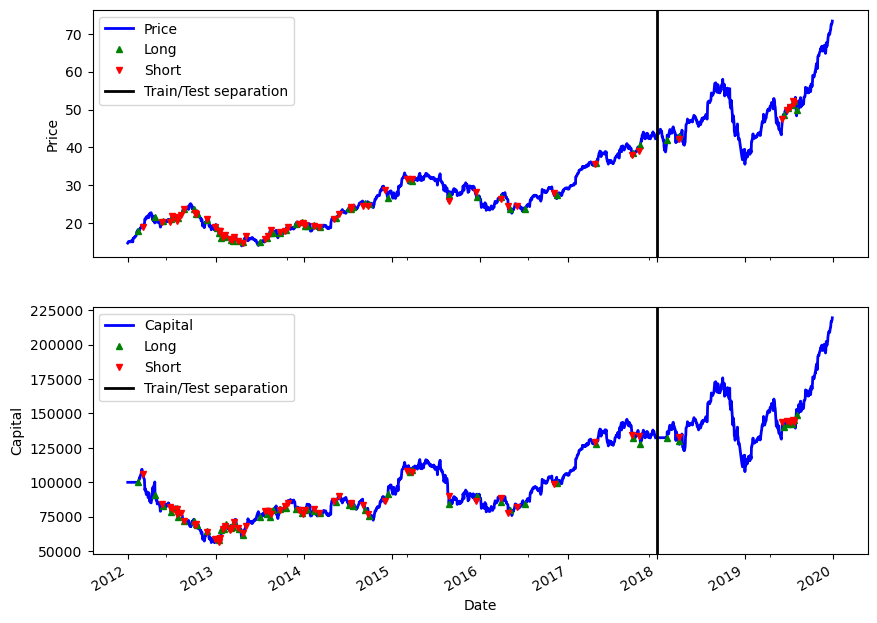

In [8]:
engineered_df = generate_strategy_for_ticker(ticker_df=engineered_df,
                                            ticker=TARGET,
                                            LLM_OUTPUT_PATH=f"{LLM_OUTPUT_PATH}/r/v5",
                                            persona=PERSONA,
                                            HIGH_RISK_PROFILE=HIGH_RISK_PROFILE,
                                            HIGH_OBJECTIVES=HIGH_OBJECTIVES,
                                            client=OPENAI_CLIENT,
                                            model=OPENAI_MODEL,
                                            strategy_yaml_file=f'{LLM_PROMPTS_PATH}/strat_prompt_v5.yml',
                                            eval_yaml_file=f'{LLM_PROMPTS_PATH}/evaluator_prompt_v2.yml',
                                            news_yaml_file=f'{LLM_PROMPTS_PATH}/news_analyst_prompt_v1.yml',
                                            start_date=STARTDATE,
                                            end_date=ENDDATE,
                                            max_news=0)

if os.path.exists(train_file) and os.path.exists(test_file) and os.path.exists(train_env_file) and os.path.exists(test_env_file):
    with open(train_file, 'rb') as f:
        train_results = pickle.load(f)
    with open(test_file, 'rb') as f:
        test_results = pickle.load(f)
    with open(train_env_file, 'rb') as f:
        train_env = pickle.load(f)
    with open(test_env_file, 'rb') as f:
        test_env = pickle.load(f)
else:
    strat, train_env, test_env = simulator.simulateNewStrategy(engineered_df.copy(),
                                                                startingDate=STARTDATE,
                                                                endingDate=ENDDATE,
                                                                splitingDate=SPLITDATE,
                                                                verbose=True,
                                                                plotTraining=True,
                                                                rendering=True,
                                                                showPerformance=True,
                                                                models_path=MODELS_PATH,
                                                                saveStrategy=True,
                                                                money=money,
                                                                observationSpace=observationSpace,
                                                                actionSpace=actionSpace,
                                                                stateLength=stateLength,
                                                                bounds=bounds,
                                                                step=step,
                                                                numberOfEpisodes=numberOfEpisodes,
                                                                transactionCosts=transactionCosts,
                                                                ticker_symbol=TARGET)
    analyser = PerformanceEstimator(train_env.data)
    train_results = analyser.getComputedPerformance()
    analyser = PerformanceEstimator(test_env.data)
    test_results = analyser.getComputedPerformance()
    with open(train_file, 'wb') as f:
        pickle.dump(train_results, f)
    with open(test_file, 'wb') as f:
        pickle.dump(test_results, f)
    with open(train_env_file, 'wb') as f:
        pickle.dump(train_env, f)
    with open(test_env_file, 'wb') as f:
        pickle.dump(test_env, f)

In [9]:
test_results

,Metric,Value
0,PnL,87005.364867
1,Cumulative Return,0.580127
2,Annualized Return,0.257821
3,Annualized Volatility,0.274568
4,Sharpe Ratio,1.073476
5,Sortino Ratio,1.299407
6,Max Drawdown,0.387234
7,Mean Drawdown Duration,18.727273
8,Profitability,0.538462
9,Avg Profit/Loss Ratio,7.982843


In [1]:
test_engineered_df = engineered_df[SPLITDATE:ENDDATE].copy()
test_engineered_df['LLM_Trade_Action'] = test_engineered_df['trade_action']
test_engineered_df['trade_action'] = test_env.data['action'] == 0
test_engineered_df['reward'] = test_env.data['returns']
llm_trading_metrics, llm_trades_df = evaluate_trading_metrics(test_engineered_df)
llm_trades_df['cumulative_returns'] = (1 + test_env.data['returns']).cumprod() - 1
llm_trading_metrics

NameError: name 'engineered_df' is not defined

In [ ]:
fig1, fig3, fig2, fig4 = plot_llm_trade(llm_trades_df, plot=False)

change_points = llm_trades_df['LLM_Trade_Action'].shift(1) != llm_trades_df['LLM_Trade_Action']
llm_changes = llm_trades_df[change_points]

longs = llm_changes[llm_changes['LLM_Trade_Action'] == 1]
flats = llm_changes[llm_changes['LLM_Trade_Action'] == 0]

fig1.axes[0].scatter(
    longs.index,
    longs['Close'],
    marker='^',
    facecolors='none',
    edgecolors='purple',
    label='LLM Long',
    s=200
)

fig1.axes[0].scatter(
    flats.index,
    flats['Close'],
    marker='v',
    facecolors='none',
    edgecolors='gray',
    label='LLM Short',
    s=200
)

fig1.axes[0].legend(loc='upper right')
for fig in [fig1, fig2, fig3, fig4]:
    if fig:
        fig.show()
        display(fig)